In [1]:
%cd ~/code/projects/nn-play/
import numpy as np
import matplotlib.pyplot as plt
import imageio
import copy
from IPython.display import HTML
%matplotlib inline
import warnings
# warnings.filterwarnings('ignore')

/home/ira/code/projects/nn-play


## Why predict?

## Environment
Consider a series of images representing a ball moving through a 2D world
Various dynamics:
* add noise to its motion 
* bounce from walls or pass through them
* add noise to observations

In [2]:
from balls_sim import World, DEFAULT_SIM_CONFIG
gif_counter = 0

In [3]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
w = World(**conf)
gif_counter += 1
ims = []
for i in range(150):
    w.run()
    ims.append(w.draw())

imageio.mimsave("ims/{}.gif".format(gif_counter), ims)
HTML('<img src="../ims/{}.gif" width="280">'.format(gif_counter))


/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [4]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
# conf['n_bodies'] = 5
conf['dynamics_noise'] = 0.3
w = World(**conf)
gif_counter += 1
ims = []
for i in range(150):
    w.run()
    ims.append(w.draw())

imageio.mimsave("ims/{}.gif".format(gif_counter), ims)
HTML('<img src="../ims/{}.gif" width="280">'.format(gif_counter))

/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [5]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
conf['wall_action'] = 'random'
w = World(**conf)
gif_counter += 1
ims = []
for i in range(150):
    w.run()
    ims.append(w.draw())

imageio.mimsave("ims/{}.gif".format(gif_counter), ims)
HTML('<img src="../ims/{}.gif" width="280">'.format(gif_counter))

/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


## Making predictions with a model
With a model of the process and model of a sensor we can form a probabilistic distributions over possible world states.
State representation is selected manually by someone who knows the environment.

Particle filter starts with perfect knowledge of state. It operates with structured data.

### Baseline for predictions

In [6]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
conf['wall_action'] = 'random'
w = World(**conf)
ims = []
for i in range(150):
    w.run()
    ims.append(w.draw())

ims_ar = np.array(ims)
av_pixel_intensity = np.mean(ims_ar)
ims_ar = np.mean((ims_ar-av_pixel_intensity)**2)
ims_ar

0.035431951

In [8]:
from particle_filter import ParticleFilter

Baseline is 0.011956417001783848


/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))
/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


Ground truth,Belief,Sample
,,


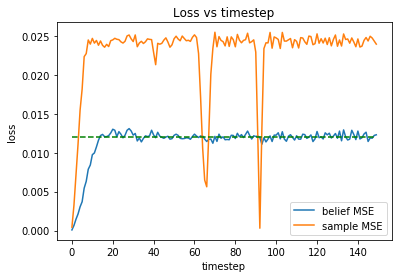

In [11]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
# conf['wall_action'] = 'bounce'
conf['radius'] = 2.0
conf['dynamics_noise'] = 0.1
conf['measurement_noise'] = 0.0003
conf['n_bodies'] = 1
# conf['ball_action'] = 'bounce'

w = World(**conf)
gif_counter += 1

pf = ParticleFilter(conf, n_particles=100)

pos = [body.pos for body in w.bodies]
vel = [body.vel for body in w.bodies]
pf.warm_start(pos, vel=vel)

ims = []

ims_percept = []
ims_belief = []
ims_sample = []

loss_mse = []
loss_sample_mse = []
loss_mae = []

for i in range(150):
#     if i < 8:
#         measures = [body.pos for body in w.bodies]
#         pf.update(measures)
#         pf.resample()
    
    w.run()
    pf.predict()
    
    percept = w.draw()
    belief = pf.draw()[:,:,0]
    sample = pf.parts[0].draw()
    
    loss_mse.append(np.mean((percept-belief)**2))
    loss_sample_mse.append(np.mean((percept-sample)**2))
    
    ims_percept.append(percept)
    ims_belief.append(belief)
    ims_sample.append(sample)


imageio.mimsave("ims/{}-percept.gif".format(gif_counter), ims_percept)
imageio.mimsave("ims/{}-belief.gif".format(gif_counter), ims_belief)
imageio.mimsave("ims/{}-sample.gif".format(gif_counter), ims_sample)

ims_ar = np.array(ims_percept)
av_pixel_intensity = np.mean(ims_ar)
baseline_level = np.mean((ims_ar-av_pixel_intensity)**2)
baseline = np.ones(len(loss_mse)) * baseline_level
print("Baseline is {}".format(baseline_level))

plt.plot(loss_mse)
plt.plot(loss_sample_mse)
plt.plot(baseline, 'g--')

plt.title("Loss vs timestep")
plt.ylabel("loss")
plt.xlabel("timestep")
plt.legend(["belief MSE", "sample MSE"])

HTML("""
<table>
  <tr>
    <th>Ground truth</th>
    <th>Belief</th> 
    <th>Sample</th>
  </tr>
  <tr>
    <td><img src="../ims/{0}-percept.gif" width="140"></td>
    <td><img src="../ims/{0}-belief.gif" width="140"></td> 
    <td><img src="../ims/{0}-sample.gif" width="140"></td>
  </tr>

</table>""".format(gif_counter))

## State tracking/predicting percepts using predictive autoencoder
Given a sequence of percepts from an environment, the network predicts later percepts.

In the process it finds a representation of the environment suitable for predictions (ie containing unobservable information)

But standard NN training results in a deterministic network, ie network that always outputs the same for a given input.

Ok for state tracking: there is a single optimal belief.

Not ok for percept prediction: in a stochastic environment there are multiple possible percepts.

Standard NN outputs a mixture of possible future percepts (itself an unrealistic percept)

## Can we sample from beliefs?
### Sampling percepts
G generates:
    * from? last belief state, noise vector
    * what? a percept
D compares:
    * Percepts created by the above method vs actual percept after the update
                
### Sampling world states
G generates:
    * from? last belief state, noise vector
    * what? a state resulting from updating last belief state with a percept
    * then? a network is initialised with this state and run for a couple of timestep to generate percepts (standard deterministic fashion)
D compares:
    * Percepts created by the above method vs actual percepts

### Limitation
Resulting state sample can still contain uncertainty (in places where update doesn't kill of all uncertainty)

## Beliefs can grow without bounds
For some kinds noise the amount of information required to describe the belief increases with time.
In such cases the network should ultimately fail, because there is fixed amount of information that can be contained in its representation.

(This is main advantage of particle filter vs Kalman filter -- PF can hold multiple separate hypothesis, KF bunches all of the hypotheses with a single descriptor)

## Can we distinguish when to branch into multiple separate hypotheses (instantiations of neural network)?
Can we use error signal for this?
